## Sample DCGAN implementation on keras
### ref:https://towardsdatascience.com/gan-by-example-using-keras-on-tensorflow-backend-1a6d515a60d0
### ref:https://elix-tech.github.io/ja/2017/02/06/gan.html

In [1]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Reshape
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D, Convolution2D

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [12]:
#  Instead of fractionally-strided convolution as suggested in DCGAN, 
# upsampling between the first three layers is used since 
# it synthesizes more realistic handwriting images.
def generator_model():
    model = Sequential()
    model.add(Dense(input_dim=100, output_dim=1024))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
#     128:batchsize 7*7:image size
    model.add(Dense(128*7*7))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Reshape((7, 7, 128), input_shape=(128*7*7,)))
    model.add(UpSampling2D((2, 2)))
    model.add((Convolution2D(64, 5, 5, border_mode='same')))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(UpSampling2D((2, 2)))
    model.add(Convolution2D(1, 5, 5, border_mode='same'))
    model.add(Activation('tanh'))
    return model

In [13]:
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Flatten, Dropout

def discriminator_model():
    model = Sequential()
    model.add(Convolution2D(64, 5, 5,
                           subsample=(2, 2),
                           border_mode='same',
                           input_shape=(28, 28, 1)))
    model.add(LeakyReLU(0.2))
    model.add(Convolution2D(128, 5, 5, subsample=(2, 2)))
    model.add(LeakyReLU(0.2))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    return model

In [31]:
import math

def combine_images(generated_images):
    total = generated_images.shape[0]
    cols = int(math.sqrt(total))
    rows = math.ceil(float(total)/cols)
    width, height = generated_images.shape[1:3]
    combined_image = np.zeros((height*rows, width*cols),
                             dtype=generated_images.dtype)
    
    for index, image in enumerate(generated_images):
        i = int(index/cols)
        j = index % cols
        combined_image[width*i:width*(i+1), height*j:height*(j+1)] = image[:, :, 0]
    return combined_image
    

In [54]:
import os
from keras.datasets import mnist
from keras.optimizers import Adam
from PIL import Image

BATCH_SIZE = 32
NUM_EPOCH = 20
GENERATED_IMAGE_PATH = 'generated_images/'

def train():
    (X_train, y_train), (_, _) = mnist.load_data()
    X_train = (X_train.astype(np.float32) - 127.5)/127.5
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
    
    discriminatar = discriminator_model()
    d_opt = Adam(lr=1e-5, beta_1=0.1)
    discriminatar.compile(loss='binary_crossentropy', optimizer=d_opt)
    
    discriminatar.trainable = False
    generator = generator_model()
    dcgan = Sequential([generator, discriminatar])
    g_opt = Adam(lr=2e-4, beta_1=0.5)
    dcgan.compile(loss='binary_crossentropy', optimizer=g_opt)
    
    num_batches = int(X_train.shape[0] / BATCH_SIZE)
    print('Number of batches: ', num_batches)
    for epoch in range(NUM_EPOCH):
        
        for index in range(num_batches):
            noise = np.array([np.random.uniform(-1, 1, 100) for _ in range(BATCH_SIZE)])
            image_batch = X_train[index*BATCH_SIZE:(index+1)*BATCH_SIZE]
            generated_images = generator.predict(noise, verbose=0)
#             print(generated_images.shape)
#             return generated_images
            
            if index % 500 == 0:
                image = combine_images(generated_images)
                image = image*127.5 + 127.5
                if not os.path.exists(GENERATED_IMAGE_PATH):
                    os.mkdir(GENERATED_IMAGE_PATH)
                
                Image.fromarray(image.astype(np.uint8))\
                    .save(GENERATED_IMAGE_PATH+"%04d_%04d.png" % (epoch, index))
            
#             update discriminator
            X = np.concatenate((image_batch, generated_images))
            y = [1]*BATCH_SIZE + [0]*BATCH_SIZE
            d_loss = discriminatar.train_on_batch(X, y)
            
#             update generator
            noise = np.array([np.random.uniform(-1, 1, 100) for _ in range(BATCH_SIZE)])
            g_loss = dcgan.train_on_batch(noise, [1]*BATCH_SIZE)
            print("epoch: %d, batch: %d, g_loss: %f, d_loss: %f" % (epoch, index, g_loss, d_loss))
            
        generator.save_weights('generator.h5')
        discriminatar.save_weights('dsiscriminator.h5')

In [ ]:
g = train()

/home/ubuntu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), input_shape=(28, 28, 1..., strides=(2, 2), padding="same")`
/home/ubuntu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (5, 5), strides=(2, 2))`
/home/ubuntu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1024, input_dim=100)`
/home/ubuntu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), padding="same")`
/home/ubuntu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(1, (5, 5), padding="same")`


Number of batches:  1875


/home/ubuntu/anaconda3/lib/python3.5/site-packages/Keras-2.0.8-py3.5.egg/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch: 0, batch: 0, g_loss: 0.662531, d_loss: 0.682538
epoch: 0, batch: 1, g_loss: 0.649665, d_loss: 0.673476
epoch: 0, batch: 2, g_loss: 0.644921, d_loss: 0.659913
epoch: 0, batch: 3, g_loss: 0.616705, d_loss: 0.655080
epoch: 0, batch: 4, g_loss: 0.607800, d_loss: 0.660094
epoch: 0, batch: 5, g_loss: 0.597571, d_loss: 0.653874
epoch: 0, batch: 6, g_loss: 0.588204, d_loss: 0.645205
epoch: 0, batch: 7, g_loss: 0.567281, d_loss: 0.647804
epoch: 0, batch: 8, g_loss: 0.567365, d_loss: 0.644096
epoch: 0, batch: 9, g_loss: 0.551373, d_loss: 0.644223
epoch: 0, batch: 10, g_loss: 0.529303, d_loss: 0.640859
epoch: 0, batch: 11, g_loss: 0.535800, d_loss: 0.630033
epoch: 0, batch: 12, g_loss: 0.535962, d_loss: 0.633618
epoch: 0, batch: 13, g_loss: 0.514422, d_loss: 0.626567
epoch: 0, batch: 14, g_loss: 0.500697, d_loss: 0.619582
epoch: 0, batch: 15, g_loss: 0.502360, d_loss: 0.620514
epoch: 0, batch: 16, g_loss: 0.485254, d_loss: 0.625570
epoch: 0, batch: 17, g_loss: 0.482272, d_loss: 0.606534
ep

In [8]:
from glob import glob
generated_images = glob("generated_images/*")

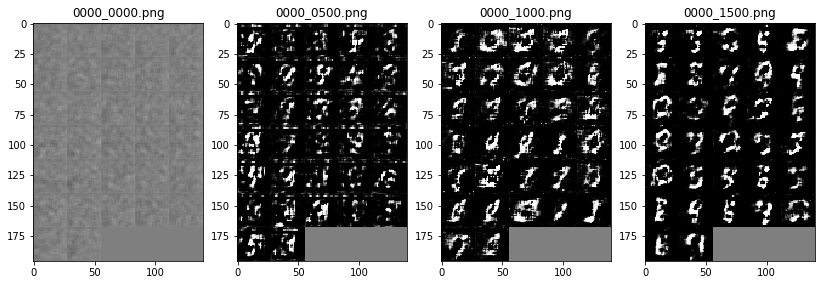

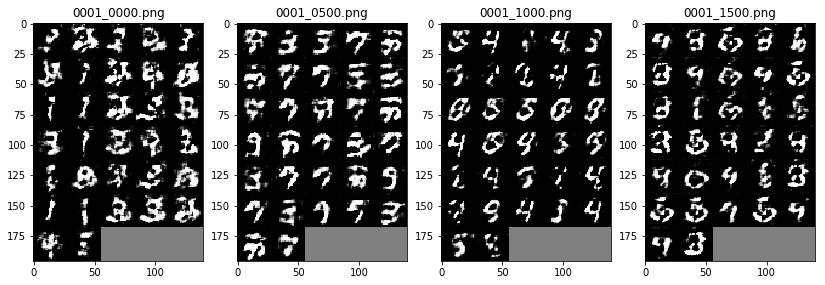

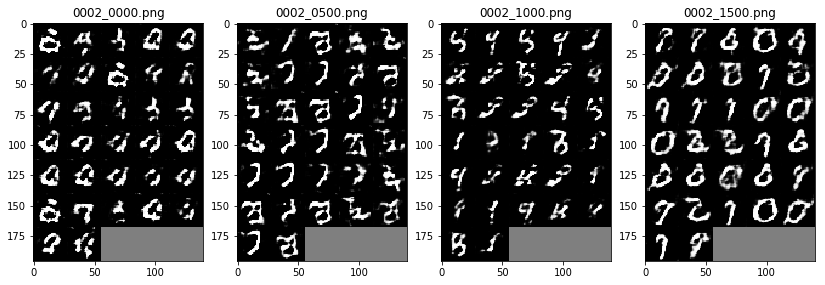

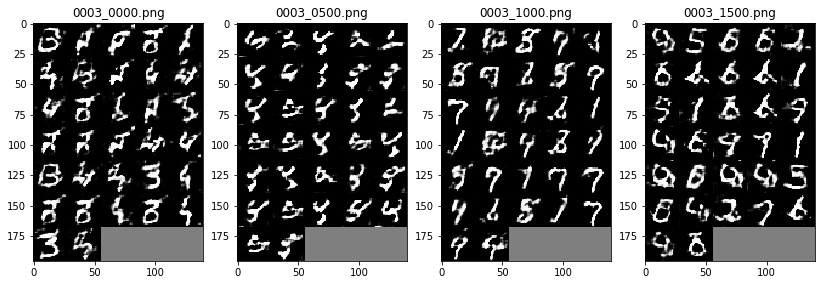

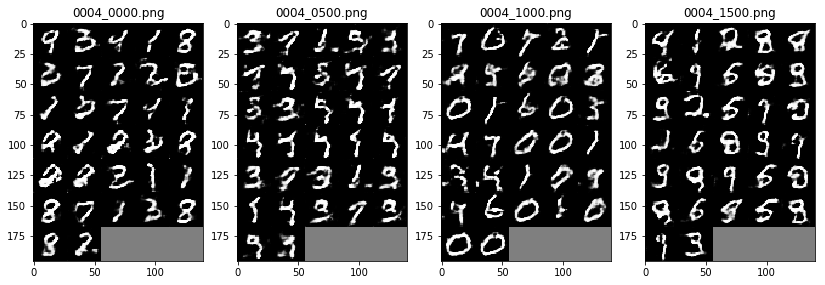

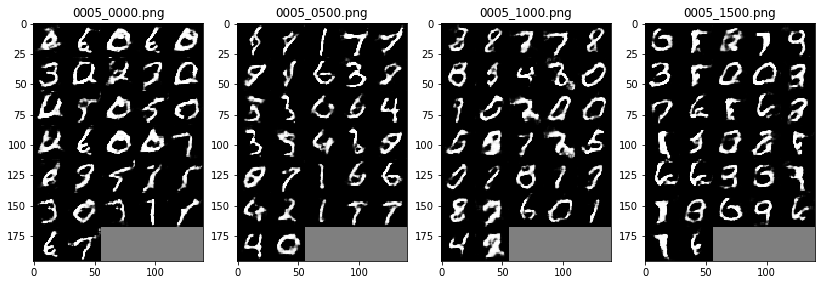

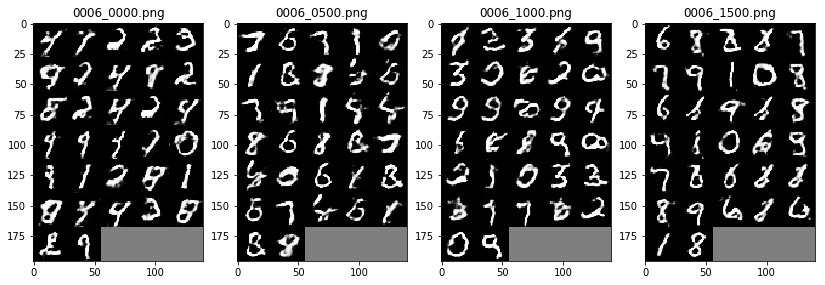

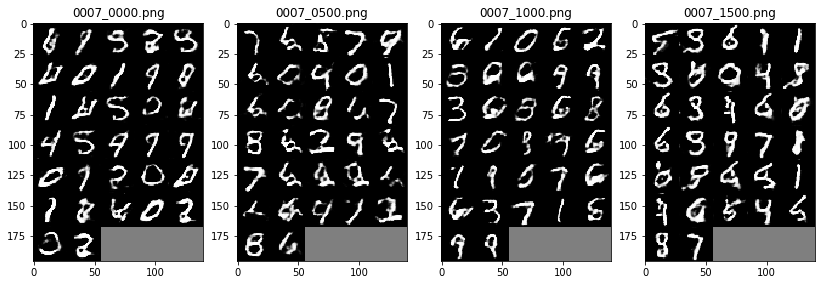

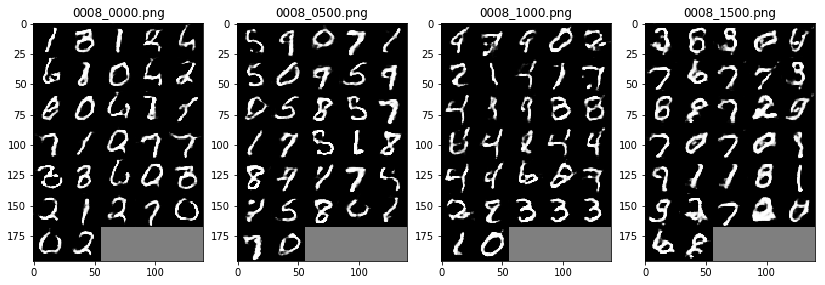

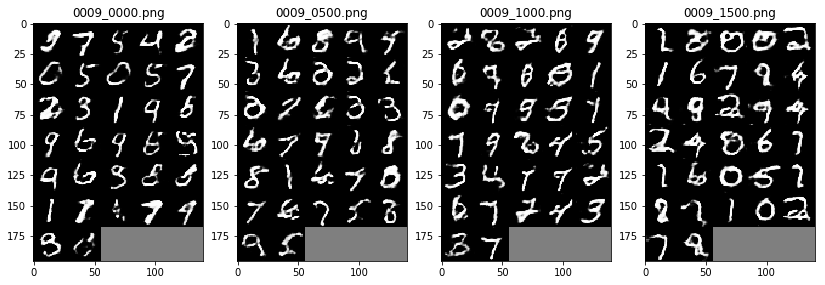

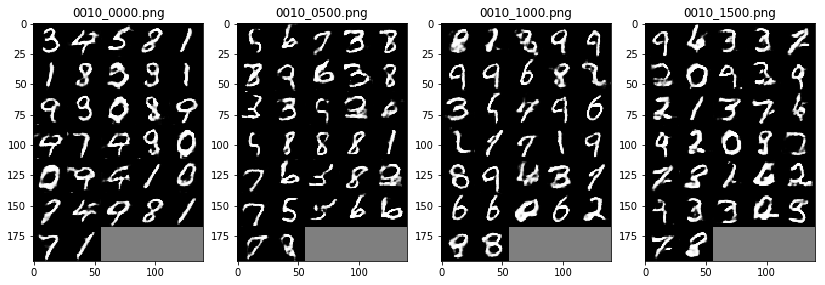

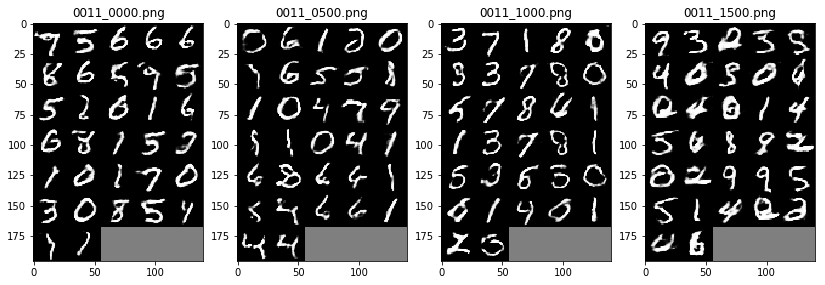

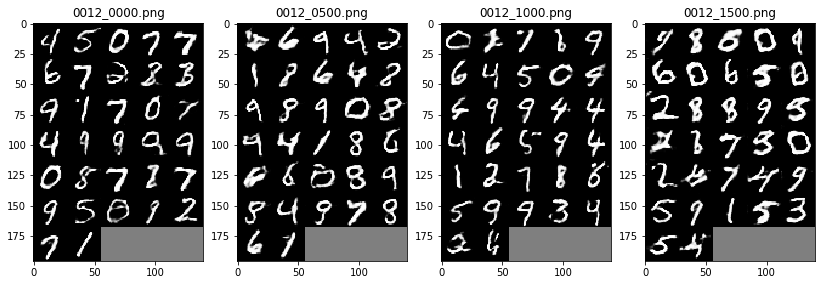

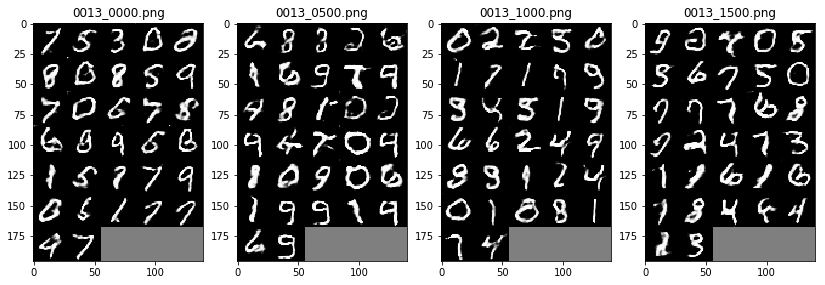

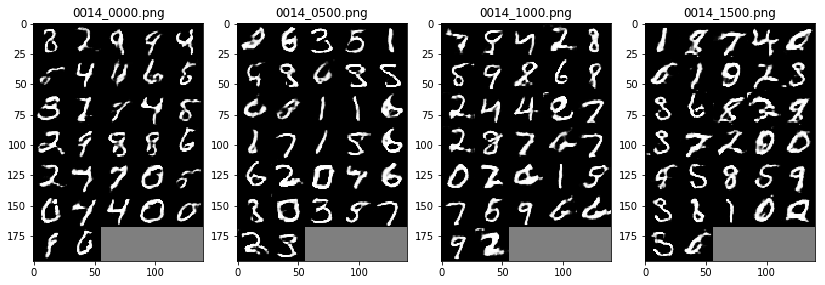

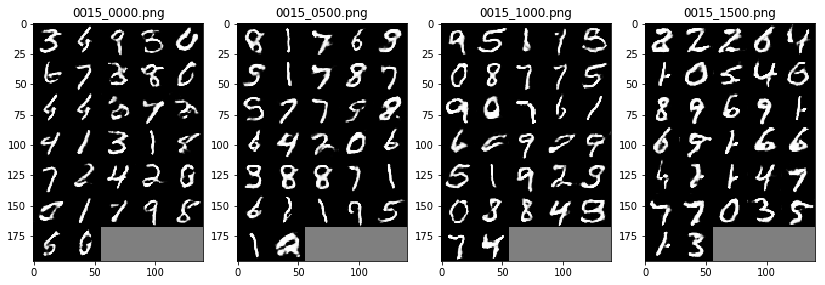

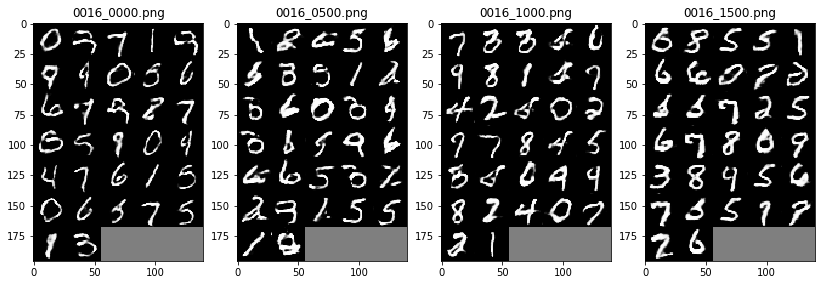

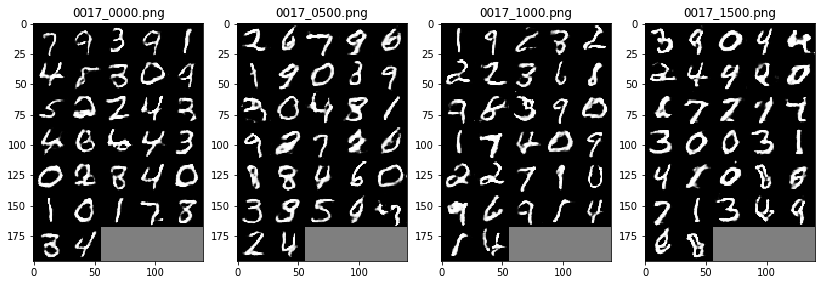

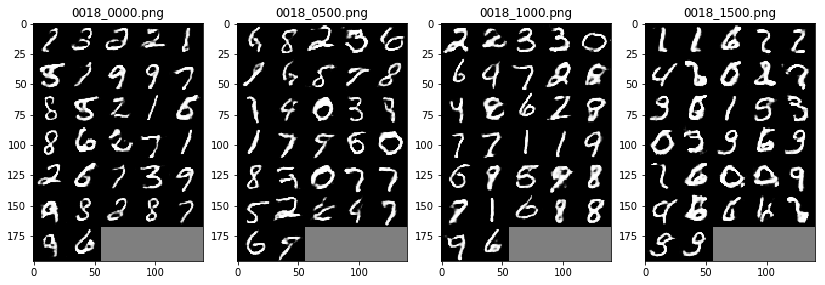

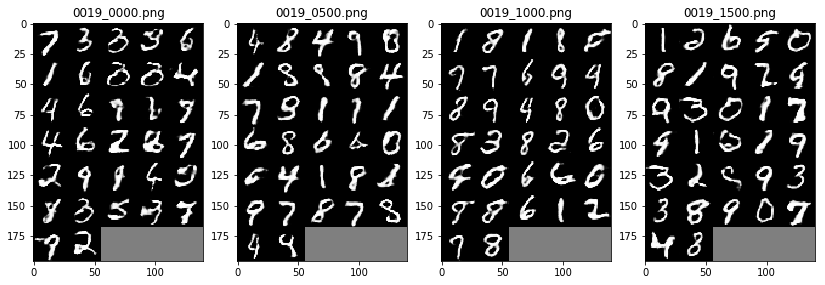

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
n = 4
counter = 0
max_counter = 100
generated_images.sort()
for im in generated_images:
    if counter % n == 0:
        plt.figure(figsize=(14, 6))
        
    plt.subplot(1, n, counter % n + 1)
    img = cv2.imread(im)
    title = im.split('/')[-1]
    plt.gray()
    plt.imshow(img)
    plt.title(title)
    counter += 1
    if counter == max_counter:
        break

In [16]:
generated_images.sort()

In [17]:
generated_images

['generated_images/0000_0000.png',
 'generated_images/0000_0500.png',
 'generated_images/0000_1000.png',
 'generated_images/0000_1500.png',
 'generated_images/0001_0000.png',
 'generated_images/0001_0500.png',
 'generated_images/0001_1000.png',
 'generated_images/0001_1500.png',
 'generated_images/0002_0000.png',
 'generated_images/0002_0500.png',
 'generated_images/0002_1000.png',
 'generated_images/0002_1500.png',
 'generated_images/0003_0000.png',
 'generated_images/0003_0500.png',
 'generated_images/0003_1000.png',
 'generated_images/0003_1500.png',
 'generated_images/0004_0000.png',
 'generated_images/0004_0500.png',
 'generated_images/0004_1000.png',
 'generated_images/0004_1500.png',
 'generated_images/0005_0000.png',
 'generated_images/0005_0500.png',
 'generated_images/0005_1000.png',
 'generated_images/0005_1500.png',
 'generated_images/0006_0000.png',
 'generated_images/0006_0500.png',
 'generated_images/0006_1000.png',
 'generated_images/0006_1500.png',
 'generated_images/0